In [1]:
%cd ../..

c:\Users\aldion\Desktop\Development\virtusize-algo


In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from src.steps.load_data import load_experiment_data
from src.steps.predict import predict_serving_data
from src.steps.train import train
from src.utils.error_analyzer import ErrorAnalyzer
from src.utils.error_calculator import calculate_split_errors, get_split_error_data
from src.utils.feature_engineer import FeatureScaler, BMIProxyEngineer, FeatureDropper
from src.utils.ground_truths import get_ground_truth_values
from src.utils.metrics import MetricsManager
from src.utils.models import ModelNames, VirtusizeModels, FitParams
from src.utils.neural_net import build_model
from src.utils.predictions import get_train_val_test_predictions




In [3]:
scaler = FeatureScaler(StandardScaler(), cols_to_scale=["age", "weight", "bmi_proxy"])
bmi_engineer = BMIProxyEngineer()
feature_droppper = FeatureDropper(["height"])
feature_engineers = [bmi_engineer,feature_droppper , scaler]


In [4]:
experiment_data = load_experiment_data(feature_engineers=feature_engineers)
train_val_test = experiment_data.train_val_test

In [5]:
train_val_test.train.bust.features.head()

,gender,age,weight,bmi_proxy
664,1,-1.005660,-0.236478,0.492185
1013,0,0.180270,-1.256858,1.588829
153,0,0.319791,-0.252298,0.199040
392,0,1.156918,-0.109919,-0.101876
3598,1,1.575482,0.538694,-0.806016


In [6]:
train_val_test.train.bust.targets.head()

664     830.0
1013    765.0
153     823.0
392     986.0
3598    976.0
Name: bust_circumference, dtype: float64

In [7]:
RF_PARAMS = {"min_samples_leaf": 20, "n_estimators": 1000, "max_depth": 8}
models = VirtusizeModels(RandomForestRegressor(**RF_PARAMS), RandomForestRegressor(**RF_PARAMS), RandomForestRegressor(**RF_PARAMS), 
                         names=ModelNames(bust="rf_bust", hip="rf_hip", waist="rf_waist"))

In [8]:
train(models, train_val_test.train)

Training bust circumference  prediction model...


Training hip circumference prediction model...
Training waist circumference prediction model...
Training complete.


TrainHistory(bust=RandomForestRegressor(max_depth=8, min_samples_leaf=20, n_estimators=1000), hip=RandomForestRegressor(max_depth=8, min_samples_leaf=20, n_estimators=1000), waist=RandomForestRegressor(max_depth=8, min_samples_leaf=20, n_estimators=1000))

### Universal Metrics Analysis

In [9]:
predictions = get_train_val_test_predictions(models, train_val_test)

In [10]:
ground_truths = get_ground_truth_values(train_val_test)

In [11]:
metrics_manager = MetricsManager()
metrics = metrics_manager.update_metrics(ground_truths, predictions)

In [12]:
metrics

,train_mae,val_mae,test_mae,train_mse,val_mse,test_mse,train_r2,val_r2,test_r2
rf_bust,21.815353,23.672912,24.640713,812.890380,972.688385,997.014758,0.889839,0.860703,0.861667
rf_hip,16.761634,18.775342,18.443083,512.965208,597.250445,586.335402,0.869375,0.838846,0.842567
rf_waist,23.792688,26.462503,24.540580,993.485695,1212.766338,979.448759,0.903816,0.882329,0.901086


In [18]:
metrics_manager.show_validation_metrics()

,val_mae,val_mse,val_r2
rf_bust,23.672912,972.688385,0.860703
rf_hip,18.775342,597.250445,0.838846
rf_waist,26.462503,1212.766338,0.882329


- The table above compares the performance of the classifiers using the metrics; mean absolute error (mae), mean squared error (mse) and r squared score. Comparing the performance of the classifiers on the train and validation sets suggests that the each classifier should generalize fairly well to unseen test  data. There is a higher degree of overfitting to the test set, however, when compared to other types of classifiers used throughout the project.

In [42]:
models.bust.feature_importances_

array([0.00744417, 0.03762477, 0.00515952, 0.94977153])

In [43]:
models.hip.feature_importances_

array([0.04161935, 0.02882491, 0.07086684, 0.85868889])

In [44]:
models.waist.feature_importances_

array([6.08593001e-04, 8.06780288e-02, 3.89110034e-03, 9.14822278e-01])

- The engineered `bmi_proxy` feature is by far the most important of the features

### Error Analysis

In [45]:
split_errors = calculate_split_errors(ground_truths.val, predictions.val)

In [46]:
error_data = get_split_error_data(ground_truths.val, predictions.val, experiment_data.original_preprocessed)

In [47]:
error_data

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
9,1,17.0,1654.0,61.3,845.0,738.0,910.0,15.893734,0.801232,-1.777844,15.893734,0.801232,1.777844
11,0,58.0,1539.0,54.6,891.0,800.0,875.0,-0.619113,23.008268,-3.566389,0.619113,23.008268,3.566389
22,0,33.0,1605.0,58.0,872.0,756.0,945.0,1.928199,-2.457651,7.963190,1.928199,2.457651,7.963190
24,1,26.0,1786.0,72.8,971.0,813.0,940.0,-53.239711,20.368747,-16.108540,53.239711,20.368747,16.108540
32,1,24.0,1715.0,70.6,906.0,789.0,977.0,12.497989,-25.438605,17.327437,12.497989,25.438605,17.327437
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5128,0,22.0,1535.0,42.5,744.0,626.0,794.0,14.712035,40.607813,8.796610,14.712035,40.607813,8.796610
5130,0,44.0,1628.0,59.3,915.0,770.0,926.0,-24.114531,17.007441,1.553069,24.114531,17.007441,1.553069
5132,1,32.0,1756.0,65.4,896.0,820.0,930.0,-17.725020,-8.087500,-61.006817,17.725020,8.087500,61.006817
5134,1,27.0,1760.0,75.0,930.0,845.0,983.0,9.506180,-14.248715,-28.344834,9.506180,14.248715,28.344834


In [48]:
error_analyzer = ErrorAnalyzer(error_data, column_num_categories_map={"age": 10, "weight": 10, "height": 10})

In [49]:
error_analyzer.get_category_means("gender")

,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,
0,33.796392,1581.417526,56.604897,871.868557,755.912371,928.855670,0.264508,-1.743981,-0.221275,24.720352,20.399699,28.457417
1,31.540682,1719.829396,71.408399,923.440945,822.645669,955.446194,4.329155,-1.763415,1.782101,22.606228,17.121141,24.430938


In [50]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

- The data above shows that the various models perform slightly better for males in general. We see that the mean absolute errors for each target is higher for females, with the biggest disparity coming in the prediction of waist circumference.
- Whereas this might indicate some bias to our model, it is not unreasonable to believe that it is more difficult to predict bust, hip and waist circumference in women. This occurrence may well then be seen in even more sophisticated models.

In [51]:
error_analyzer.get_category_st_devs("gender")

,gender,age,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
gender,,,,,,,,,,,,,
0,0.000000,15.720736,57.415612,8.383898,77.880663,91.530416,53.723949,32.648276,26.150443,37.222816,21.328012,16.454161,23.995050
1,0.000000,14.449534,60.511423,12.170386,81.087263,100.117794,64.685635,29.307700,22.424479,32.149566,19.147881,14.588811,20.973787


- The standard deviations confirms that the models performed better when making predictions for males.

In [52]:
error_analyzer.get_category_counts("gender")

gender
0    388
1    381
dtype: int64

In [53]:
male_error_data = error_data[error_data["gender"] == 1]
female_error_data = error_data[error_data["gender"] == 0]

#### The charts below show the distributions of the absolute errors for both genders

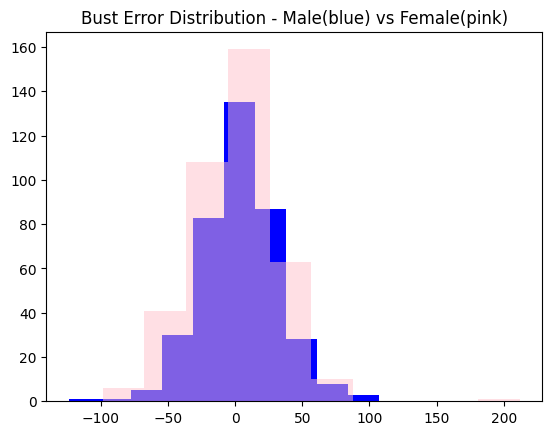

In [54]:
plt.hist(male_error_data["bust_errors"], bins=10, color="blue")
plt.hist(female_error_data["bust_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Bust Error Distribution - Male(blue) vs Female(pink)")
plt.show()


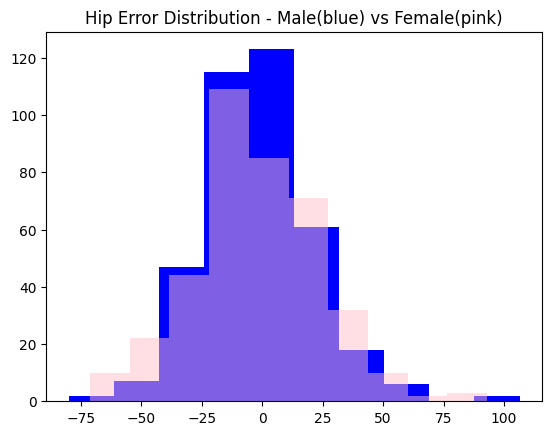

In [55]:
plt.hist(male_error_data["hip_errors"], bins=10, color="blue")
plt.hist(female_error_data["hip_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Hip Error Distribution - Male(blue) vs Female(pink)")
plt.show()

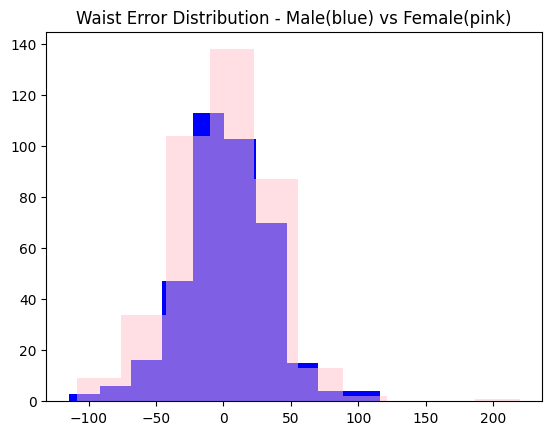

In [56]:
plt.hist(male_error_data["waist_errors"], bins=10, color="blue")
plt.hist(female_error_data["waist_errors"], alpha=0.5, bins=10, color="pink")
plt.title("Waist Error Distribution - Male(blue) vs Female(pink)")
plt.show()

- The graphs indicate a relatively similar distribution of errors but do confirm higher error rates when predicting female data.

### Further Error Analysis

In [57]:
error_analyzer.get_category_counts("age")

age
0    259
1     80
2     86
3     82
4     57
5     40
6     47
7     56
8     36
9     26
dtype: int64

In [58]:
error_analyzer.get_category_bin("age", 0)
# Most of the examples have individuals aged 15 to 20

(14.946, 20.4)

In [59]:
error_analyzer.get_category_means("age")

,gender,height,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
age,,,,,,,,,,,,
0,0.513514,1662.366795,61.010425,857.243243,735.849421,934.563707,3.345912,-6.352409,1.494244,24.144450,18.145763,23.338801
1,0.537500,1676.100000,65.787500,891.850000,776.862500,953.250000,6.512066,-1.051987,0.539378,21.375279,17.674769,26.073147
2,0.523256,1677.267442,67.083721,909.267442,795.174419,960.802326,-0.362637,-3.191256,1.205912,22.605768,21.034219,28.966496
3,0.524390,1670.195122,67.046341,917.768293,812.073171,952.475610,-2.050715,3.326135,-1.424940,20.702208,15.540274,25.381387
4,0.614035,1664.631579,66.975439,916.105263,812.807018,949.315789,3.093812,-2.312444,7.250137,23.728490,16.502830,25.008271
5,0.400000,1617.050000,61.337500,896.100000,791.125000,923.800000,4.798719,2.797576,5.383674,24.920438,22.395079,31.920389
6,0.425532,1616.170213,66.459574,940.744681,856.914894,950.234043,6.439528,1.441973,-9.120285,24.626162,21.509990,23.844274
7,0.375000,1598.482143,64.594643,949.375000,854.464286,935.803571,-3.221826,4.976138,3.755490,24.984942,20.722432,32.568728
8,0.250000,1566.388889,62.022222,933.944444,854.416667,927.611111,7.433607,5.360028,0.757196,27.429129,19.954050,36.404279


- We can see that the bust circumference prediction and waist circumference prediction models do generally worse when making predictions for older people. The opposite is true for hip circumference prediction. We did see earlier that age was not a very important feature for any of  the models, so these results by themselves do communicate significant remedial actions that may be taken.

In [60]:
error_analyzer.get_category_means("height")

,gender,age,weight,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
height,,,,,,,,,,,,
0,0.000000,46.928571,52.392857,884.714286,781.000000,894.428571,4.630379,10.836994,0.057693,17.254069,20.121675,23.130717
1,0.000000,45.564103,54.374359,897.871795,800.897436,905.179487,-4.581247,8.533072,-16.984995,26.307923,27.073226,30.677616
2,0.010638,37.489362,55.229787,876.106383,770.148936,921.712766,1.332501,-3.242099,-6.336510,24.750457,20.997224,30.629491
3,0.084615,33.669231,56.565385,870.069231,753.300000,928.938462,-1.724321,-4.968131,-0.305362,24.221592,19.675409,26.202940
4,0.330769,31.230769,59.563077,867.438462,756.230769,926.515385,6.028979,1.047349,3.272060,25.323504,18.151777,26.912272
5,0.740385,31.605769,67.067308,911.250000,800.269231,946.451923,1.187384,-0.416638,7.041320,21.392627,17.649549,23.600868
6,0.941667,30.550000,70.316667,917.108333,810.958333,955.008333,3.199481,-3.322051,4.514002,22.097414,16.245784,23.486958
7,0.975610,27.731707,75.653659,938.268293,834.170732,977.743902,4.671671,-0.947233,1.664933,24.821468,16.968584,25.815055
8,1.000000,26.545455,76.129545,926.136364,823.159091,982.363636,6.309727,-11.377982,-1.008006,21.822429,18.359943,28.262897


In [61]:
error_analyzer.get_category_counts("height")

height
0     14
1     39
2     94
3    130
4    130
5    104
6    120
7     82
8     44
9     12
dtype: int64

- In general the  models perform worse for people whose heights lie further away from the central height values

In [62]:
error_analyzer.get_category_means("weight")

,gender,age,height,bust_circumference,waist_circumference,hip_circumference,bust_errors,hip_errors,waist_errors,bust_errors_absolute,hip_errors_absolute,waist_errors_absolute
weight,,,,,,,,,,,,
0,0.066667,28.693333,1566.146667,780.666667,661.080000,860.880000,3.136661,-6.098927,-2.771672,22.492053,19.746312,21.236293
1,0.191489,31.638298,1595.622340,843.643617,721.611702,903.765957,-2.481801,-0.219358,0.861244,22.989282,18.370284,23.082278
2,0.399038,33.557692,1630.548077,889.658654,780.144231,937.884615,3.732575,-3.388733,-2.138135,21.380772,18.168848,27.112878
3,0.822695,33.631206,1703.921986,929.808511,819.659574,955.879433,-1.620402,-0.538802,4.389215,25.142750,16.752517,26.415547
4,0.872340,35.819149,1717.457447,967.776596,875.542553,993.776596,9.741994,-1.508474,5.843912,24.591150,19.555616,27.873312
5,0.921053,33.500000,1749.657895,1018.421053,938.000000,1036.500000,7.001653,-4.684187,-1.553324,26.089845,19.015788,33.557480
6,0.933333,25.733333,1743.933333,1065.133333,1005.733333,1063.533333,16.072960,22.921142,0.702325,39.136002,33.843741,51.232223
7,1.000000,31.428571,1784.714286,1092.571429,1040.714286,1114.000000,18.015803,4.461622,4.909753,25.581251,24.235729,32.913456
8,1.000000,22.000000,1806.500000,1128.000000,1061.000000,1159.000000,5.153313,-22.125846,22.246572,5.153313,22.125846,22.246572


In [63]:
error_analyzer.get_category_counts("weight")

weight
0     75
1    188
2    208
3    141
4     94
5     38
6     15
7      7
8      2
9      1
dtype: int64

- Models  do comparatively worse as the weight of the individual increases. This pattern matches the weight distribution of the data, so this may indicate that the models may be improved by training on more examples of people with higher weights. This of course will likely impact the performance with individuals in other weight categories. 

### Unseen Targets Test Set Predictions

In [64]:
predict_serving_data(models, feature_engineers=feature_engineers, data_path="data/test.csv", save_path="data/rf1_predicted.csv")

No data for train split so split was not scaled.
No data for val split so split was not scaled.


,gender,age,height,weight,bust_circumference,hip_circumference,waist_circumference
0,M,27,"1,729",74.7,945.441159,969.006587,830.608701
1,M,25,"1,645",58.6,863.790342,893.037658,737.241264
2,M,28,"1,786",75.2,932.730192,969.093630,817.703747
3,M,19,"1,686",60.8,858.655458,903.052466,731.850160
4,M,24,"1,764",68.3,891.654243,939.406637,769.799182
...,...,...,...,...,...,...,...
1279,F,33,"1,618",54.0,831.214550,914.425852,707.658799
1280,F,25,"1,549",56.4,874.257190,947.068377,754.851850
1281,F,28,"1,623",58.5,867.678433,946.995586,752.319623
1282,F,34,"1,566",55.4,863.044777,934.261634,757.190161
